In [122]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math

## Пункт A:

### Интеграл для p-value (Критерий Пирсона)

In [48]:
f = lambda x: (1/2) ** (9/2) * (16 / (105 * np.sqrt(np.pi))) * (x ** (7/2)) * np.exp(-x/2)

I = quad(f, 16.4, np.inf)[0]
print(f'p-value integral I = {I:.3f}')

p-value integral I = 0.059


### Проверка по критерию Колмогорова

#### Построим эмпирическую функцию распределения

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0, 0.05, 0.13, 0.19, 0.31, 0.45, 0.63, 0.74, 0.8, 0.93, 1.0]


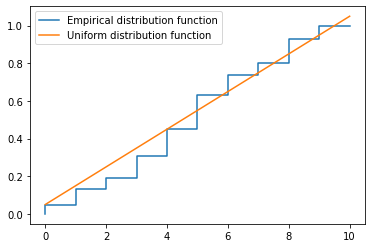

In [138]:
n = 100
x = np.arange(0, 10.5, 1)
print(x)
y = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]
y_full = []
for i in range(len(y)):
    for j in range(y[i]):
        y_full.append(i)

def f(x):
    return (x / 10) + 0.05

cumulative_y = [0]

for i in range(len(y)):
    cumulative_y.append(cumulative_y[-1] + y[i] / n)
    
plt.step(x, cumulative_y, label='Empirical distribution function')
plt.plot(f(np.arange(0, 10.5, 1)), label='Uniform distribution function')
plt.legend()

print(cumulative_y)

In [50]:
delta = np.sqrt(n) * np.max([np.max([abs(cumulative_y[i] - f(x[i])), abs(cumulative_y[i] - f(x[i])) ]) for i in range(len(x) - 1)])

print(f'Дельта с волной: {delta}')


Дельта с волной: 1.5999999999999996


In [51]:
k = 100
kolmog_sum = 0

for i in range(1, k + 1):
    kolmog_sum += (-1) ** i * np.exp(-2 * i ** (2) * delta ** 2)

kolmog_sum = 1 + 2 * kolmog_sum


In [52]:
p_val = 1 - kolmog_sum
print(f'p-value = {p_val}')

p-value = 0.01195204323919663


## Пункт B:

### Численное нахождение $\theta_1$ и $\theta_2$ из метода максимального правдоподобия

In [53]:
def p(x, theta_1, theta_2, left, right):
    return 1/(theta_2 * (2* np.pi)**0.5) * (quad(lambda x: np.exp(-0.5*((x-theta_1)/theta_2)**2), left, right)[0])

# Функция правдоподобия
def L(theta_1, theta_2):
    p0 = p(0, theta_1, theta_2, -np.inf, 0.5)
    p1 = p(1, theta_1, theta_2, 0.5, 1.5)
    p2 = p(2, theta_1, theta_2, 1.5, 2.5)
    p3 = p(3, theta_1, theta_2, 2.5, 3.5)            
    p4 = p(4, theta_1, theta_2, 3.5, 4.5)
    p5 = p(5, theta_1, theta_2, 4.5, 5.5)
    p6 = p(6, theta_1, theta_2, 5.5, 6.5)
    p7 = p(7, theta_1, theta_2, 6.5, 7.5)
    p8 = p(8, theta_1, theta_2, 7.5, 8.5)
    p9 = p(9, theta_1, theta_2, 8.5, np.inf)  
                
    return p0**5 * p1**8 * p2**6 * p3**12 * p4**14 * p5**18 * p6**11 * p7**6 * p8**13 * p9**7    

t1 = t2 = m = L_val = 0
# Численно максимизируем функцию правдоподобия
for theta_1 in np.linspace(2, 5, 200):
    for theta_2 in np.linspace(1, 5, 200):
        L_val = L(theta_1, theta_2)
        if (m < L_val):
            m = L_val
            t1 = theta_1
            t2 = theta_2
print(f'Theta 1 = {t1}, Theta 2 = {t2}')

Theta 1 = 4.788944723618091, Theta 2 = 2.6884422110552766


In [74]:
delta = 0
ps = []
ps.append(p(0, t1, t2, -np.inf, 0.5))
ps.append(p(1, t1, t2, 0.5, 1.5))
ps.append(p(2, t1, t2, 1.5, 2.5))
ps.append(p(3, t1, t2, 2.5, 3.5))           
ps.append(p(4, t1, t2, 3.5, 4.5))
ps.append(p(5, t1, t2, 4.5, 5.5))
ps.append(p(6, t1, t2, 5.5, 6.5))
ps.append(p(7, t1, t2, 6.5, 7.5))
ps.append(p(8, t1, t2, 7.5, 8.5))
ps.append(p(9, t1, t2, 8.5, np.inf)) 

for i in range(10):
    delta += ((y[i] - n * ps[i])**2) / (n * ps[i])

print(f'Дельта с волной = {delta} (мера отклонения)')

Дельта с волной = 9.799176506179462 (мера отклонения)


In [55]:
f = lambda x: 0.5**(7/2)/((15 * np.pi) / 8)*np.exp(-x/2)*x**(5/2)
p_value = quad(f, delta, np.inf)[0]
print(f'p-value = {p_value}')

p-value = 0.11297471903896593


### А теперь по Колмогорову (параметрический Бутстрап)

In [165]:
# Подвыборки берутся из модели с оцененными параметрами по методу моментов
N = 50000
deltas = []
    
# оценки методом моментов
def omm(data):
    theta1 = theta2 = 0
    for i in range(10):
        theta1 += 1/100 * i * data[i]
        theta2 += 1/100 * i*i * data[i]
    theta2 = (theta2 - theta1**2)**0.5
    return (theta1, theta2)

def OMM(data):
    a1 = sum(data)/len(data)
    a2 = 0
    for i in range(len(data)):
        a2 += data[i]**2
    a2 /= len(data)
    b = (a2 - a1**2)**0.5
    return (a1,b)

# параметры главной модели
theta_1, theta_2 = omm(y)

def get_delta_kolmogorov(data, theta1, theta2):
    x_down = []
    x_up = []
    x_real = []
    
    ps = [p(0, theta1, theta2, -math.inf, data[0])]
    for i in range(1, len(data)):
        ps.append(p(0, theta1, theta2, data[i-1], data[i]))
        
    x_real.append(ps[0])
        
    for i in range(1, len(data)):
        x_real.append(ps[i] + x_real[i-1])
    
    for i in range(len(data)):
        
        x_down.append(i*0.01)
        x_up.append(i*0.01+0.01)
    ret = 0
    for i in range(100):
        d = max(abs(x_real[i] - x_down[i]), abs(x_real[i]- x_up[i]))
        if d > ret:
            ret = d
    return ret

# считаем дельту главной выборки
main_delta = 10 * get_delta_kolmogorov(y_full, theta_1, theta_2)
print(f'Дельта главной выборки: {main_delta}')

# превращаем выборку в дискретную
def discr_sample(sample):
    for i in range(len(sample)):
        if (sample[i] < 0.5): sample[i] = 0
        if (sample[i] >= 0.5 and sample[i] < 1.5): sample[i] = 1
        if (sample[i] >= 1.5 and sample[i] < 2.5): sample[i] = 2
        if (sample[i] >= 2.5 and sample[i] < 3.5): sample[i] = 3
        if (sample[i] >= 3.5 and sample[i] < 4.5): sample[i] = 4
        if (sample[i] >= 4.5 and sample[i] < 5.5): sample[i] = 5
        if (sample[i] >= 5.5 and sample[i] < 6.5): sample[i] = 6
        if (sample[i] >= 6.5 and sample[i] < 7.5): sample[i] = 7
        if (sample[i] >= 7.5 and sample[i] < 8.5): sample[i] = 8
        if (sample[i] >= 8.5): sample[i] = 9
    return sample

def boot_delta(theta_1, theta_2):
    
    # генерируем подвыборку из главной модельки
    sample = discr_sample(np.random.normal(theta_1, theta_2, 100))
    sample.sort()
    
    

    # внутренние оценки параметров
    th_1, th_2 = OMM(sample)
    
    # опеределяем внутреннюю дельту по Колмогорову
    curr_delta = 10 * get_delta_kolmogorov(sample, th_1, th_2)
    return curr_delta
            
        
# считаем 50000 дельт
for i in range(N):
    deltas.append(boot_delta(theta_1, theta_2))
        

deltas = np.sort(deltas)

# найдем k
k = 0
for i  in range(len(deltas) - 1):
    if deltas[i] < main_delta and deltas[i+1] >= main_delta:
        k = i
        break

p_val = 1 - k/N
print(f'p-value = {p_val}')




Дельта главной выборки: 1.0133711124224243
p-value = 0.83522


## Пункт С:

In [117]:
delta = 0
ps = []
ps.append(p(0, theta_1, theta_2, -np.inf, 0.5))
ps.append(p(1, theta_1, theta_2, 0.5, 1.5))
ps.append(p(2, theta_1, theta_2, 1.5, 2.5))
ps.append(p(3, theta_1, theta_2, 2.5, 3.5))           
ps.append(p(4, theta_1, theta_2, 3.5, 4.5))
ps.append(p(5, theta_1, theta_2, 4.5, 5.5))
ps.append(p(6, theta_1, theta_2, 5.5, 6.5))
ps.append(p(7, theta_1, theta_2, 6.5, 7.5))
ps.append(p(8, theta_1, theta_2, 7.5, 8.5))
ps.append(p(9, theta_1, theta_2, 8.5, np.inf)) 

for i in range(10):
    delta += ((y[i] - n * ps[i])**2) / (n * ps[i])

print(f'Дельта с волной = {delta} (мера отклонения)')

Дельта с волной = 10.798973140499793 (мера отклонения)


In [121]:
# распределение критерия найдем бутстрапом

deltas = []

for i in range(N):
    deltas.append(boot_delta(theta_1, theta_2))

deltas = np.sort(deltas)

In [124]:
x = []
y = []
for i in range(len(deltas)):
    x.append(deltas[i])
    y.append(i/N)

    
def Xi2(k, x):
    def f(x):
        return 0.5**(k/2)/math.gamma(k/2)*math.exp(-x/2)*x**(k/2-1)
    y = []
    for el in x:
        y.append(quad(f, 0, el)[0])
    return y

y9 = Xi2(9, x)
y7 = Xi2(7, x)

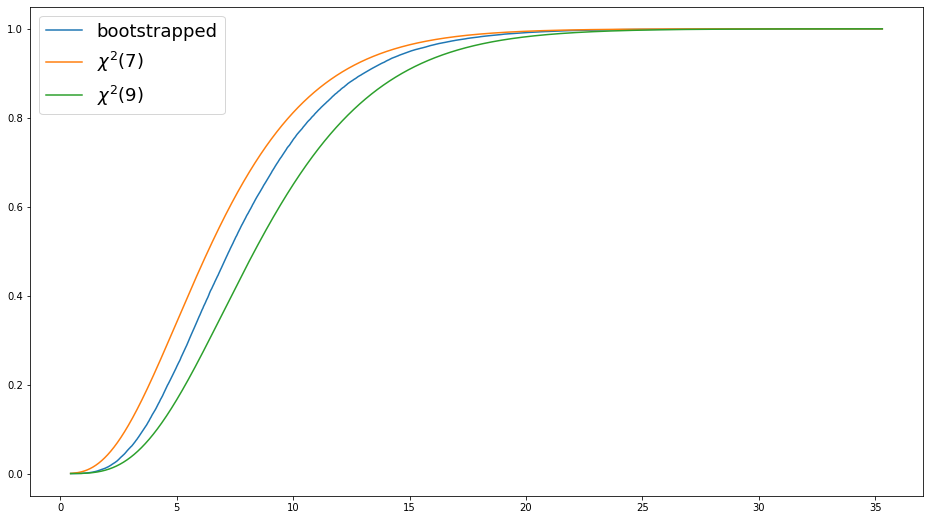

In [126]:
plt.figure(figsize=(16,9))
plt.plot(x, y, label='bootstrapped')
plt.plot(x, y7, label = '$\chi^2(7)$')
plt.plot(x, y9, label= '$\chi^2(9)$')
plt.legend(prop={'size': 18})